#**Using Python libraries for Handling WaPOR Data**
#Notebook 2 : Temporal data aggregation

In this Notebook we will show you how to do temporal aggregation of WaPOR data.  

The steps we are going to follow are:
1. Install and load necessary packages to manage rasterfiles
2. Load the .zip file from Download_WaPORv3_data Notebook to this session (or create a new .zip)
3. Unzip the files
4. Open and inspect one .tif file
>+Exercise 1 (answers needed for the MOOC quiz)
5. Perform the temporal aggregation (sum) of the decadal ET & export result to local drive
>+Exercise 2 (answers needed for the MOOC quiz)
6. More detailed temporal aggregation by date
>+Exercise 3 (answers needed for the MOOC quiz)
7. Open and inspect the result in QGIS
>+Quiz question (answer needed for the MOOC quiz)

**Data needed:**

In this notebook we will use WaPORv3 data which you can download using the [Download_WaPORv3_Data Notebook](https://github.com/wateraccounting/WaPORMOOC/blob/main/1_WaPOR_download_colab/Download_WaPORv3_Data.ipynb)  For this Notebook we are using the area Wad Helal in the Gezira Irrigation Scheme (you can find the "Wad_Helal_projected.geojson" file in the data folder of [WaPORMOOC](https://github.com/wateraccounting/WaPORMOOC/tree/main/data)). Download Level 3 dekadal data of AETI for the period 2022-10-01 to 2023-04-30, this period coinsides with the winter wheat season in Gezira scheme. This data will be used to produce the total seasonal AETI for the winter wheat season in this area. More information on the Gezira Scheme can be found in the MOOC materials.

### **Step 1**


In [ ]:
!pip install rioxarray --quiet

In [ ]:
import os
import glob
import datetime
import xarray as xr
import rioxarray as rio
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

### **Step 2 - Create a .zip file/Upload an existing .zip files**
We will now upload a .zip file containing a series of .tif files to our session: wapor_data.zip.
   
Execute the command below and navigate to where you have saved the .zip file from Topic3_N01 in your local drive.

(If you are uploading your own .tif files, you can first create a .zip archive from these files, you may need to install compression software such as 7zip (https://www.7-zip.org/) or WinRAR (https://www.win-rar.com/) to perform this operation.)

In [ ]:
#To upload file.
uploaded = files.upload()

### **Step 3 - Unzip files**
Unzip the file you have uploaded.
The command is:
 !unzip 'file_path.zip' -d 'folder_to_unzip_path'
Replace the file name in the cell below with the name of your own file. You can find the path to your file by clicking on the 3 dots next to the file name in your file explorer to the left and selecting *Copy path*. (If you do not see your files to the left, click on the folder icon to expand the Files panel)


In [ ]:
# unzip the uploaded zipfile
!unzip '/content/data.zip' -d '/content/'

### **Step 4 - Opening and inspecting one .tif file**
Before performing any operations let us open one of our tif files using the rioxarray package.

In [ ]:
# Open first raster from your unzipped files and mask out nan values
ds = rio.open_rasterio('/content/data/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-10-01.tif')
ds = ds.where(ds!=ds.attrs['_FillValue'])

In [ ]:
# Inspect the contents - How many pixels does the raster contain?
ds

In [ ]:
#The values contained are stored as an array with each value representing one pixel.
ds.values

In [ ]:
# We can produce a quick map of our data using the plot function
ds[0].plot()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box') #this command will equally space the x and y units

In [ ]:
#check the min, max and mean values
print(np.nanmin(ds.values), np.nanmax(ds.values), np.nanmean(ds.values))

⚡**EXERCISE 1**: write code to find the min, max and mean for the 1st decad of 2023 - note down the the values (rounded to the nearest integer, no decimals), you will need to enter these in the MOOC quiz.

In [ ]:
## Enter your code
#Open appropriate raster file with rioxarray and convert the nans


# Print the min, max and mean values


What happens if you dont convert the nans?

### **Step 5 - Seasonal ET from decadal ET**
We will now create one raster file which contains the seasonal ET value for our area. For this we simply need to loop through the ET files, and add up the values.   
The glob function allows us to list files in a folder matching a specific pattern.
For example:  
`glob.glob('/content/L3-AETI-D/*.tif')  `  

will produce a list of all files with the .tif extension contained in the *L3-AETI-D* folder,
while:   
`glob.glob('/content/L3-AETI-D/*2022-10*.tif')`

will produce a list of all files with the .tif extension which also have the string *202210* in the filename - these will be all of the files from October 2022.


In [ ]:
# Example to get files from October 2022
glob.glob('data/L3-AETI-D/*2022-10*.tif')

Let's produce a seasonal file for our whole time period (this will add up all the files in the folder):

In [ ]:
for i, fp in enumerate(glob.glob('data/L3-AETI-D/*.tif')):
  fn = os.path.basename(fp)
  # OPEN DATA
  ds = rio.open_rasterio(fp)
  ds = ds.where(ds!=ds.attrs['_FillValue'])
  if i == 0:
    ds_sum = ds #Initialize sum if we are looking at the first raster
  else:
    ds_sum += ds #This is the pythonic way of writing ds_sum = ds_sum + ds

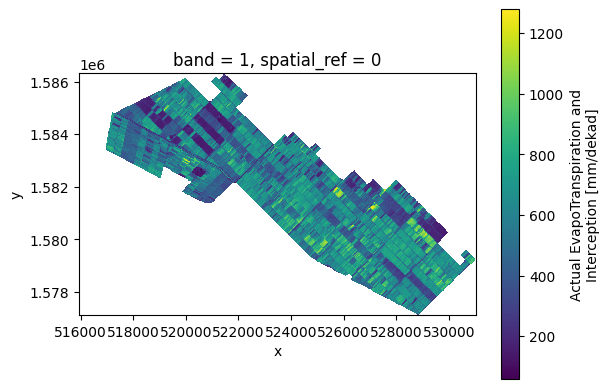

In [ ]:
ds_sum.plot()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box') #this command will equally space the x and y units

If we inspect the Attributes of ds_sum, you will notice they no longer correspond to our dataset - a consequence of this is the wrong legend on the map produced above - **we do not have 1200mm/decad of ET!** (note that if you used d_sum = d_sum + ds instead of d_sum += ds, the attributes will simply have been removed in the result).     
We can **update the Attributes** below.

In [ ]:
#Inspect Attributes to see which ones we will update
attrs = ds_sum.attrs
attrs

In [ ]:
attrs.update({'start_date': '2022-10-01',
              'end_date': '2023-04-30',
              'units' : 'mm/season'})
del attrs['number_of_days']

ds_sum.attrs  = attrs

In [ ]:
ds_sum.plot()
ax = plt.gca()
ax.set_aspect('equal', adjustable='box') #this command will equally space the x and y units

In [ ]:
# Save the seasonal sum to a tiff file and download to your local drive
ds_sum.rio.to_raster("seasonal_et.tif")
files.download(r'/content/seasonal_et.tif')

⚡ **EXERCISE 2**: write code to produce the monthly sum of AETI for April 2023, find the min, max and mean - note down the the values (rounded to the nearest integer, no decimals), you will need to enter these in the MOOC quiz!

In [ ]:
## Enter your code
#Loop through the correct files to produce a sum for April 2023

glob.glob('data/L3-AETI-D/*2023-04*.tif')


# Print the min, max and mean values
print(np.nanmin(ds.values), np.nanmax(ds.values), np.nanmean(ds.values))



### **Step 6** - More detailed temporal aggregation
So far we have done aggregation for:
1.   all files available
2.   all files with an easily recognisable pattern in the file name     

We will now learn how to select **only files within a specified time period**, for example between the start and end of season.

To do this we will:


1.   Obtain a list of all dates for the availabile files as datetime objects
2.   Define a start and end date
3.   Select only files names for which the date falls between the start and end dates

To start we will get a list of the filenames and extract the date from the name: you can observe that the date is contained in the last 10 characters before the file extension.


In [ ]:
fnames = glob.glob('/content/data/L3-AETI-D/*.tif')
fnames

Let's see how we can isolate the date on one filename:

In [ ]:
path1 = fnames[0]
path1

You should see a path that looks something like:     

`/content/L3-AETI-D/Wad_Helal_projected.GEZ_L3-AETI-D_NONE_dekad_converted_2022-11-21.tif`

We want to extract the date, e.g. in this case: '2022-11-21'     
Because all of the file names have the same formatting, ending with the date and .tif, we can simply extract the corresponding characters by counting their position from the end of the string:    
*   the date is located between the character located 14 positions from the end, and the character located 4 positions from the end.





In [ ]:
date0 = path1[-14:-4] #[-14:-4] selects characters in the string: starts at the 14th from the end, to 4th from the end
print(date0)

This is now a *string*. In oder to be able to do operations and comparisons between dates, we need to convert it to a datetime object. We can use the datetime library for this.
The datetime.strptime function allows us to go from a string to a datetime object, you can read the documentation [here](https://docs.python.org/3/library/datetime.html#strftime-strptime-behavior).

In [ ]:
date0 =  datetime.datetime.strptime(date0, '%Y-%m-%d')
date0

We can now produce a list with all the dates corresponding to our filenames:

In [ ]:
file_dates = []
for path0 in fnames:
  date0 = datetime.datetime.strptime(path0[-14:-4], '%Y-%m-%d')
  file_dates.append(date0)

In [ ]:
file_dates

We now have a list of datetimes. Note that this can be done more succintly with the following command:


```
[fname[-14:-4] for d in fnames]
```

We will now define the start and end dates of our season and find the files which are located between these dates:



In [ ]:
sos = datetime.datetime(2022,10,1) #start of season date, we use datetime.datetime to convert the year, month, day to a datetime object
eos = datetime.datetime(2023,2,28) #end of season date

Finally, we will check which dates from our list fall between the start and end date so we can select only the filenames corresponding to our season.      

**note: this is a simplified code and it does not a) Check whether all files from the season are present b) Deal with seasons which do not start and end at the beginning and end of a dekad**

In [ ]:
selected_files = []
for i, date in enumerate(file_dates):
  if (date >= sos and date < eos):
    selected_files.append(fnames[i])
selected_files

It can be hard to check if all the files you want are there as they are not sorted, to adjust this you can simply run the following:

In [ ]:
sorted(selected_files)

If you are interested, another, more elegant way to achieve this result can be done with the following code:
```
mask = [(ds >= sos and ds < eos) for ds in file_dates]
fnames_array = np.array(fnames)
selected_files = fnames_array[mask]
```



⚡ **EXERCISE 3**: write code to produce the sum of AETI for the period between 21/01/2023 and 10/04/2023, find the min, max and mean - note down the the values (rounded to the nearest integer, no decimals), you will need to enter these in the MOOC quiz!

In [ ]:
## Enter your code
#Create the list of files for the season between 21/01/2023 and 10/04/2023
sos = datetime.datetime(2023,1,21) #start of season date, we use datetime.datetime to convert the year, month, day to a datetime object
eos = datetime.datetime(2023,4,10) #end of season date
selected_files = []
for i, date in enumerate(file_dates):
  if (date >= sos and date < eos):
    selected_files.append(fnames[i])
selected_files

#Compute the sum
for i, fp in enumerate(selected_files):
  fn = os.path.basename(fp)
  # OPEN DATA
  ds = rio.open_rasterio(fp)
  ds = ds.where(ds!=ds.attrs['_FillValue'])
  if i == 0:
    ds_sum = ds #Initialize sum if we are looking at the first raster
  else:
    ds_sum += ds #This is the pythonic way of writing ds_sum = ds_sum + ds


# Print the min, max and mean values
print(np.nanmin(ds.values), np.nanmax(ds.values), np.nanmean(ds.values))


### **Step 7** - Open your data in QGIS
Open the seasonal AETI file you have downloaded in QGIS as well as the shapefile for the area.  
Do you notice anything in the extent?  
What do you think explains the observation:
>a.   The projection is different     
b.   The WaPOR Level 3 data does not cover the whole area    
c.   The shapefile is wrong    
d.   The spatial resolution doesn't match    



⚡ You will enter the answer to this question in the MOOC Quiz

You now know how write scripts to aggregate WaPOR data. In the next notebook we will show you more how to run scripts specifically developed for the WaPOR project that do the temporal aggregation and using loops for calculating seasonal data for multiple seasons.